# Module 1 - Using GPT-3.5-turbo for sentence classification

This notebook presents an example of how to use the GPT-3.5-turbo model to perform sentiment analysis. Sentiment analysis, also referred to as opinion mining, is a type of text classification task in Natural Language Processing (NLP) that involves categorizing a piece of text, typically a sentence or a document, into predefined sentiment categories, such as positive, negative, or neutral.


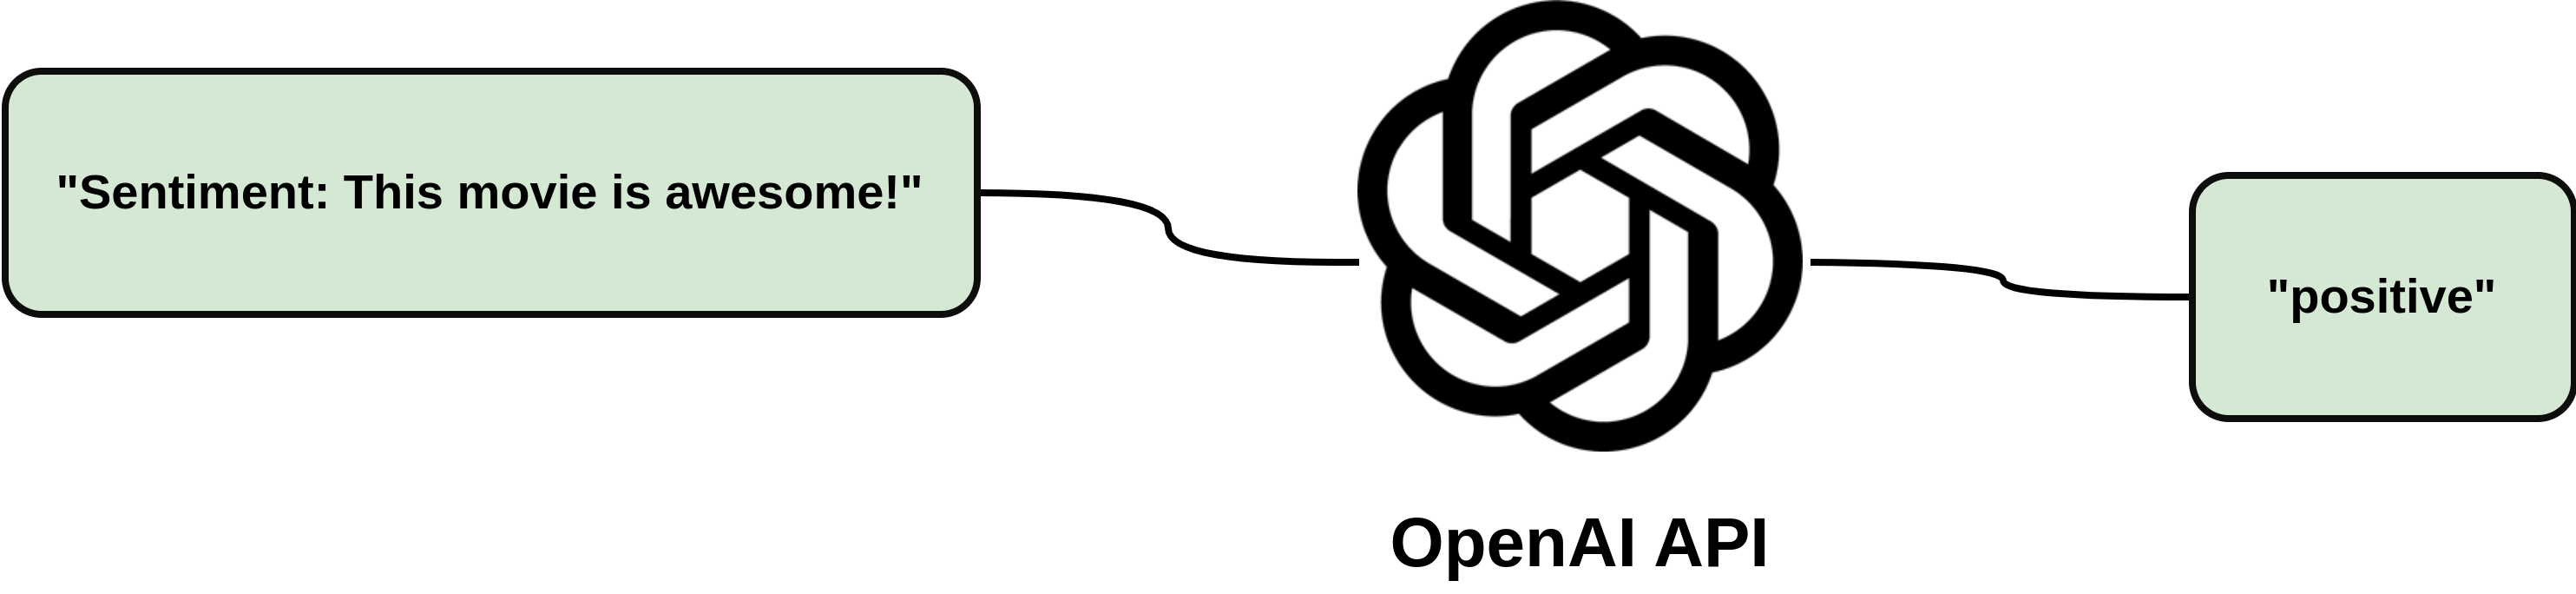

In this notebook, we will be using the GPT-3.5-turbo model which is available through the [OpenAI API](https://platform.openai.com/docs/api-reference). GPT-3.5-turbo is a state-of-the-art language model that has been fine-tuned on a vast amount of data, allowing it to generate highly coherent and contextually relevant text. With its impressive capabilities in natural language processing, GPT-3.5-turbo has become a go-to model for a wide range of NLP tasks, including sentiment analysis, machine translation, and text generation, among others.

In this example, we use the Stanford Sentiment Treebank (SST-2) as a dataset, which is available online:

* [Dataset](https://huggingface.co/datasets/glue/viewer/sst2/test)

# Installing required packages

In this example, we have to install two libraries:  `openai`, and `datasets`.

**`openai`**:

OpenAI is an artificial intelligence research laboratory consisting of the for-profit corporation OpenAI LP and its parent company, the non-profit OpenAI Inc. The OpenAI library is a powerful machine learning library that provides an easy-to-use interface to the OpenAI API. With this library, users can easily integrate OpenAI's state-of-the-art language models, including GPT-3, into their applications, and leverage the full power of these models to perform various natural language processing (NLP) tasks, such as language generation, classification, question-answering, and more.

**`datasets`**:

Datasets is an open-source library developed by [Hugging Face](https://huggingface.co/) that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more. The library provides a unified API to access these datasets, making it easy to load, process, and analyze them.

In [ ]:
!pip install openai
!pip install datasets

# Downloading Dataset

The SST-2 dataset, or the Stanford Sentiment Treebank, is popular for sentiment analysis tasks in Natural Language Processing (NLP). It consists of movie reviews from the Rotten Tomatoes website that are labeled with either a positive or negative sentiment. The dataset contains 10,662 sentence-level movie reviews, with approximately half of the reviews labeled as positive and the other half labeled as negative. The reviews are also relatively evenly distributed in length, with a median length of 18 tokens.

The SST-2 dataset has become a benchmark dataset for sentiment analysis in NLP, and many researchers use it to evaluate the performance of their models. The dataset's popularity is partly due to its high-quality labels and the task's relative simplicity, making it an accessible starting point for researchers and developers new to NLP.

In this example, we're using the **`datasets`** library to download and load the validation set of the dataset.

In [ ]:
from datasets import load_dataset

test_dataset = load_dataset('glue', 'sst2', split='validation')
test_dataset = test_dataset.select(range(100))

train_dataset = load_dataset('glue', 'sst2', split='train')
train_dataset = test_dataset.map(lambda example: {'label_name': "positive" if example["label"] == 1 else "negative"})

In this code, we use the **`pandas`** library to import the SST-2 dataset and show the first 10 examples using the **`df.head(10)`** method. The dataset contains examples labeled as either 0 or 1, representing negative and positive, respectively. For instance, the first example is labeled as 1, which means it is a positive example. It reads "it's a charming and often affecting journey," while the second example is labeled as 0, meaning it is a negative example. It reads "unflinchingly bleak and desperate." This way, you can have a quick overview of the dataset and its labeling.

In [ ]:
import pandas as pd

df = pd.DataFrame(test_dataset)
df.head(10)

,sentence,label,idx
0,it 's a charming and often affecting journey .,1,0
1,unflinchingly bleak and desperate,0,1
2,allows us to hope that nolan is poised to emba...,1,2
3,"the acting , costumes , music , cinematography...",1,3
4,"it 's slow -- very , very slow .",0,4
5,although laced with humor and a few fanciful t...,1,5
6,a sometimes tedious film .,0,6
7,or doing last year 's taxes with your ex-wife .,0,7
8,you do n't have to know about music to appreci...,1,8
9,"in exactly 89 minutes , most of which passed a...",0,9


# Using OpenAI API

The code snippet below shows an example of how to use the OpenAI API for sentiment analysis. It begins by getting the API key from the [Google Colab Secrets](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75). Then, a function `sentiment_analysis` is defined that takes in a text string as input. The function creates a prompt string by appending the input text to a sentence asking to classify it as positive or negative. This prompt is then passed to the **`openai.ChatCompletion.create`** method along with the name of the GPT-3.5-turbo model to use and a temperature value of 0. The method returns a response that contains the predicted sentiment classification (positive or negative).

In the given code, **`temperature=0`** is a parameter that is passed to the **`openai.ChatCompletion.create()`** function call. Temperature is a hyperparameter in natural language processing (NLP) models like GPT-3 that controls the degree of randomness in the output of the model. A higher temperature value leads to more diverse and unpredictable responses, while a lower temperature value results in more conservative and predictable responses.

When **`temperature=0`**, it means that the model will always output the most probable token at each step, resulting in the most deterministic and conservative output possible.

Without providing the model any training examples, this type of prompt is referred to as a **zero-shot prompt**.

In [ ]:
from google.colab import userdata
OPENAI_KEY = userdata.get('openai_api_key')

In [ ]:
import os

from openai import OpenAI
client = OpenAI(api_key=OPENAI_KEY)

def sentiment_analysis(text):
  prompt = f"Classify the following sentence as positive or negative.\nSentence: {text}\nClass:"
  response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": prompt}],
    temperature=0
  )
  return response.choices[0].message.content


The next cell shows how to use the model in a **few-shot** manner:

In [ ]:
import random,json
def few_shot_sentiment_analysis(text, k_shot=3):
  # add the system instructions - define the task
  messages = [
      {"role":"system","content":"Your task is to classify sentences' sentiment as 'positive' or 'negative'."}
  ]

  # Add the few-shot examples using the `user` and `assistant`roles
  idxs = random.sample(list(range(len(train_dataset))), k_shot)
  for example in train_dataset.select(idxs):
    messages.append({
        "role": "user", "content": f"Sentence: {example['sentence']}"
    })
    messages.append({
        "role":"assistant", "content": f"Class: {example['label_name']}"
    })

  # add the target sentence as a user message
  messages.append({
      "role": "user", "content": f"Sentence: {text}"
  })

  response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=messages,
    temperature=0
  )
  return response.choices[0].message.content.split(":")[-1].strip()


# Model Evaluation

The code below demonstrates the model evaluation process for sentiment analysis. Firstly, the **`load_metric()`** function is used to load the accuracy metric, which will be used to evaluate the model's performance. Then, the references and predictions lists are initialized to empty lists, which will be used to store the true labels and predicted labels, respectively.

The for loop iterates over each item in the **`test_dataset`**, and for each item, the true label is added to the **`references`** list, and the **`sentiment_analysis()`** function is called to get the predicted sentiment label for the given sentence. The predicted label is then converted to a binary value of 1 (positive) or 0 (negative) and added to the predictions list.

Finally, the **`metric.compute()`** function is called, passing in the **`predictions`** and **`references`** lists as arguments. This computes the accuracy of the model by comparing the predicted labels with the true labels and returns the accuracy score. The **`tqdm`** library is used to display a progress bar during the iteration process.

In [ ]:
from datasets import load_metric
from tqdm import tqdm

metric = load_metric("accuracy")

references = []
predictions = []

ds = test_dataset.select(range(1))
for item in tqdm(test_dataset):
  references.append(item['label'])
  pred = sentiment_analysis(item['sentence'])
  predictions.append(1 if pred == "positive" else 0)

metric.compute(predictions=predictions, references=references)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


{'accuracy': 0.48}

Using **few-shot** examples:

In [ ]:
k_shot = 3 # @param
references = []
predictions = []
for item in tqdm(test_dataset):
  references.append(item['label'])
  pred = few_shot_sentiment_analysis(item['sentence'], k_shot)
  predictions.append(1 if pred == "positive" else 0)

metric.compute(predictions=predictions, references=references)

100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


{'accuracy': 0.99}

# Try it yourself

You can try sentiment analysis with your own sentences by providing the input text as a string to the **`text`** variable in the code snippet provided below.


In [ ]:
text = "This movie is awesome!" # @param
class_label = sentiment_analysis(text)
print(f"The sentence '{text}' is classified as '{class_label}'.")